# Check differences with new boundary conditions

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cmocean
import pandas as pd
import pickle
import xarray as xr
import matplotlib

%matplotlib inline

#### Parameters

In [5]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

# folders:
fcont_old = '/data/brogalla/run_storage/river-continental-202112/'
fcont_new = '/data/brogalla/run_storage/river-continental-202206/'
fglac_old = '/data/brogalla/run_storage/river-glacial-202112/'
fglac_new = '/data/brogalla/run_storage/river-glacial-202206/'
fseas_old = '/data/brogalla/run_storage/river-seasonal-202202/'
fseas_new = '/data/brogalla/run_storage/river-seasonal-202206/'

#### Load files

In [8]:
model_ref    = nc.Dataset(f'{fcont_old}ANHA12_continental-2002_20211130/ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20020101-20020105.nc')
lon_model    = np.array(model_ref.variables['nav_lon'])
lat_model    = np.array(model_ref.variables['nav_lat'])
depths_model = np.array(model_ref.variables['deptht'])

In [9]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
ANHA12_lon = np.array(mesh.variables['nav_lon'])
ANHA12_lat = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

In [10]:
# Mn model run results:

# Continental:
fco = xr.open_dataset(f'{fcont_old}ANHA12_continental-2004_20211130/ANHA12_EXH006_2004_monthly.nc')
fcn = xr.open_dataset(f'{fcont_new}ANHA12_continental-2004_20220607/ANHA12_EXH006_2004_monthly.nc')
dMn_co = fco['dissolmn'].values[:,0,:,:,:]*1e9
dMn_cn = fcn['dissolmn'].values[:,0,:,:,:]*1e9

# Glacial:
fgo = xr.open_dataset(f'{fglac_old}ANHA12_glacial-2004_20211130/ANHA12_EXH006_2004_monthly.nc')
fgn = xr.open_dataset(f'{fglac_new}ANHA12_glacial-2004_20220607/ANHA12_EXH006_2004_monthly.nc')
dMn_go = fgo['dissolmn'].values[:,0,:,:,:]*1e9
dMn_gn = fgn['dissolmn'].values[:,0,:,:,:]*1e9

# Seasonal:
fso = xr.open_dataset(f'{fseas_old}ANHA12_seasonal-2004_20220215/ANHA12_EXH006_2004_monthly.nc')
fsn = xr.open_dataset(f'{fseas_new}ANHA12_seasonal-2004_20220607/ANHA12_EXH006_2004_monthly.nc')
dMn_so = fso['dissolmn'].values[:,0,:,:,:]*1e9
dMn_sn = fsn['dissolmn'].values[:,0,:,:,:]*1e9

#### Functions

In [11]:
def plot_slice(mn_model_old, mn_model_new, vmax1=10, vmax2=2, vmax2_step=0.1):
    
    fig, ax1, ax2, ax3, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/diff-panels.pickle','rb'))

    # Plot model background field:
    ax1.set_title('Old experiment', fontsize=7)
    ax2.set_title('New experiment', fontsize=7)
    ax3.set_title('New minus old experiment', fontsize=7)
    x_model, y_model = proj(lon_model, lat_model)
    CS1 = proj.pcolormesh(x_model, y_model, mn_model_old, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, zorder=2, ax=ax1) #ref
    CS2 = proj.pcolormesh(x_model, y_model, mn_model_new, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, zorder=2, ax=ax2) #exp
    CS3 = proj.pcolormesh(x_model, y_model, mn_model_new-mn_model_old, \
                          vmin=-vmax2, vmax=vmax2, cmap=cmocean.cm.balance, zorder=2, ax=ax3) #difference
    
    for axis in [ax1, ax2, ax3]:
        # add bathymetry contours:
        x, y = proj(ANHA12_lon, ANHA12_lat)
        proj.contour(x, y, mesh_bathy, levels=[1000,2000,3000], linewidths=0.2, colors='k', zorder=3, ax=axis)
        proj.drawcoastlines(color='#373736', linewidth=1.0, ax=axis)
    
    cbar_ax1 = fig.add_axes([0.220, 0.663, 0.01, 0.09])
    cbar_ax2 = fig.add_axes([0.540, 0.663, 0.01, 0.09])
    cbar_ax3 = fig.add_axes([0.220, 0.15, 0.02, 0.16])
    
    # Colorbar:
    CBar1 = plt.colorbar(CS1, cax=cbar_ax1, ticks=np.arange(0, vmax1+2, 2))
    CBar2 = plt.colorbar(CS2, cax=cbar_ax2, ticks=np.arange(0, vmax1+2, 2))
    CBar3 = plt.colorbar(CS3, cax=cbar_ax3, ticks=np.arange(-vmax2-1, vmax2+1, vmax2_step))    
    
    for CBar in [CBar1, CBar2, CBar3]:
        CBar.ax.tick_params(labelsize=5) 
        CBar.set_label('dMn [nM]', fontsize=5)
        
    CBar3.ax.tick_params(labelsize=7) 
    CBar3.set_label('dMn change [nM]', fontsize=7)
    return

#### Figures

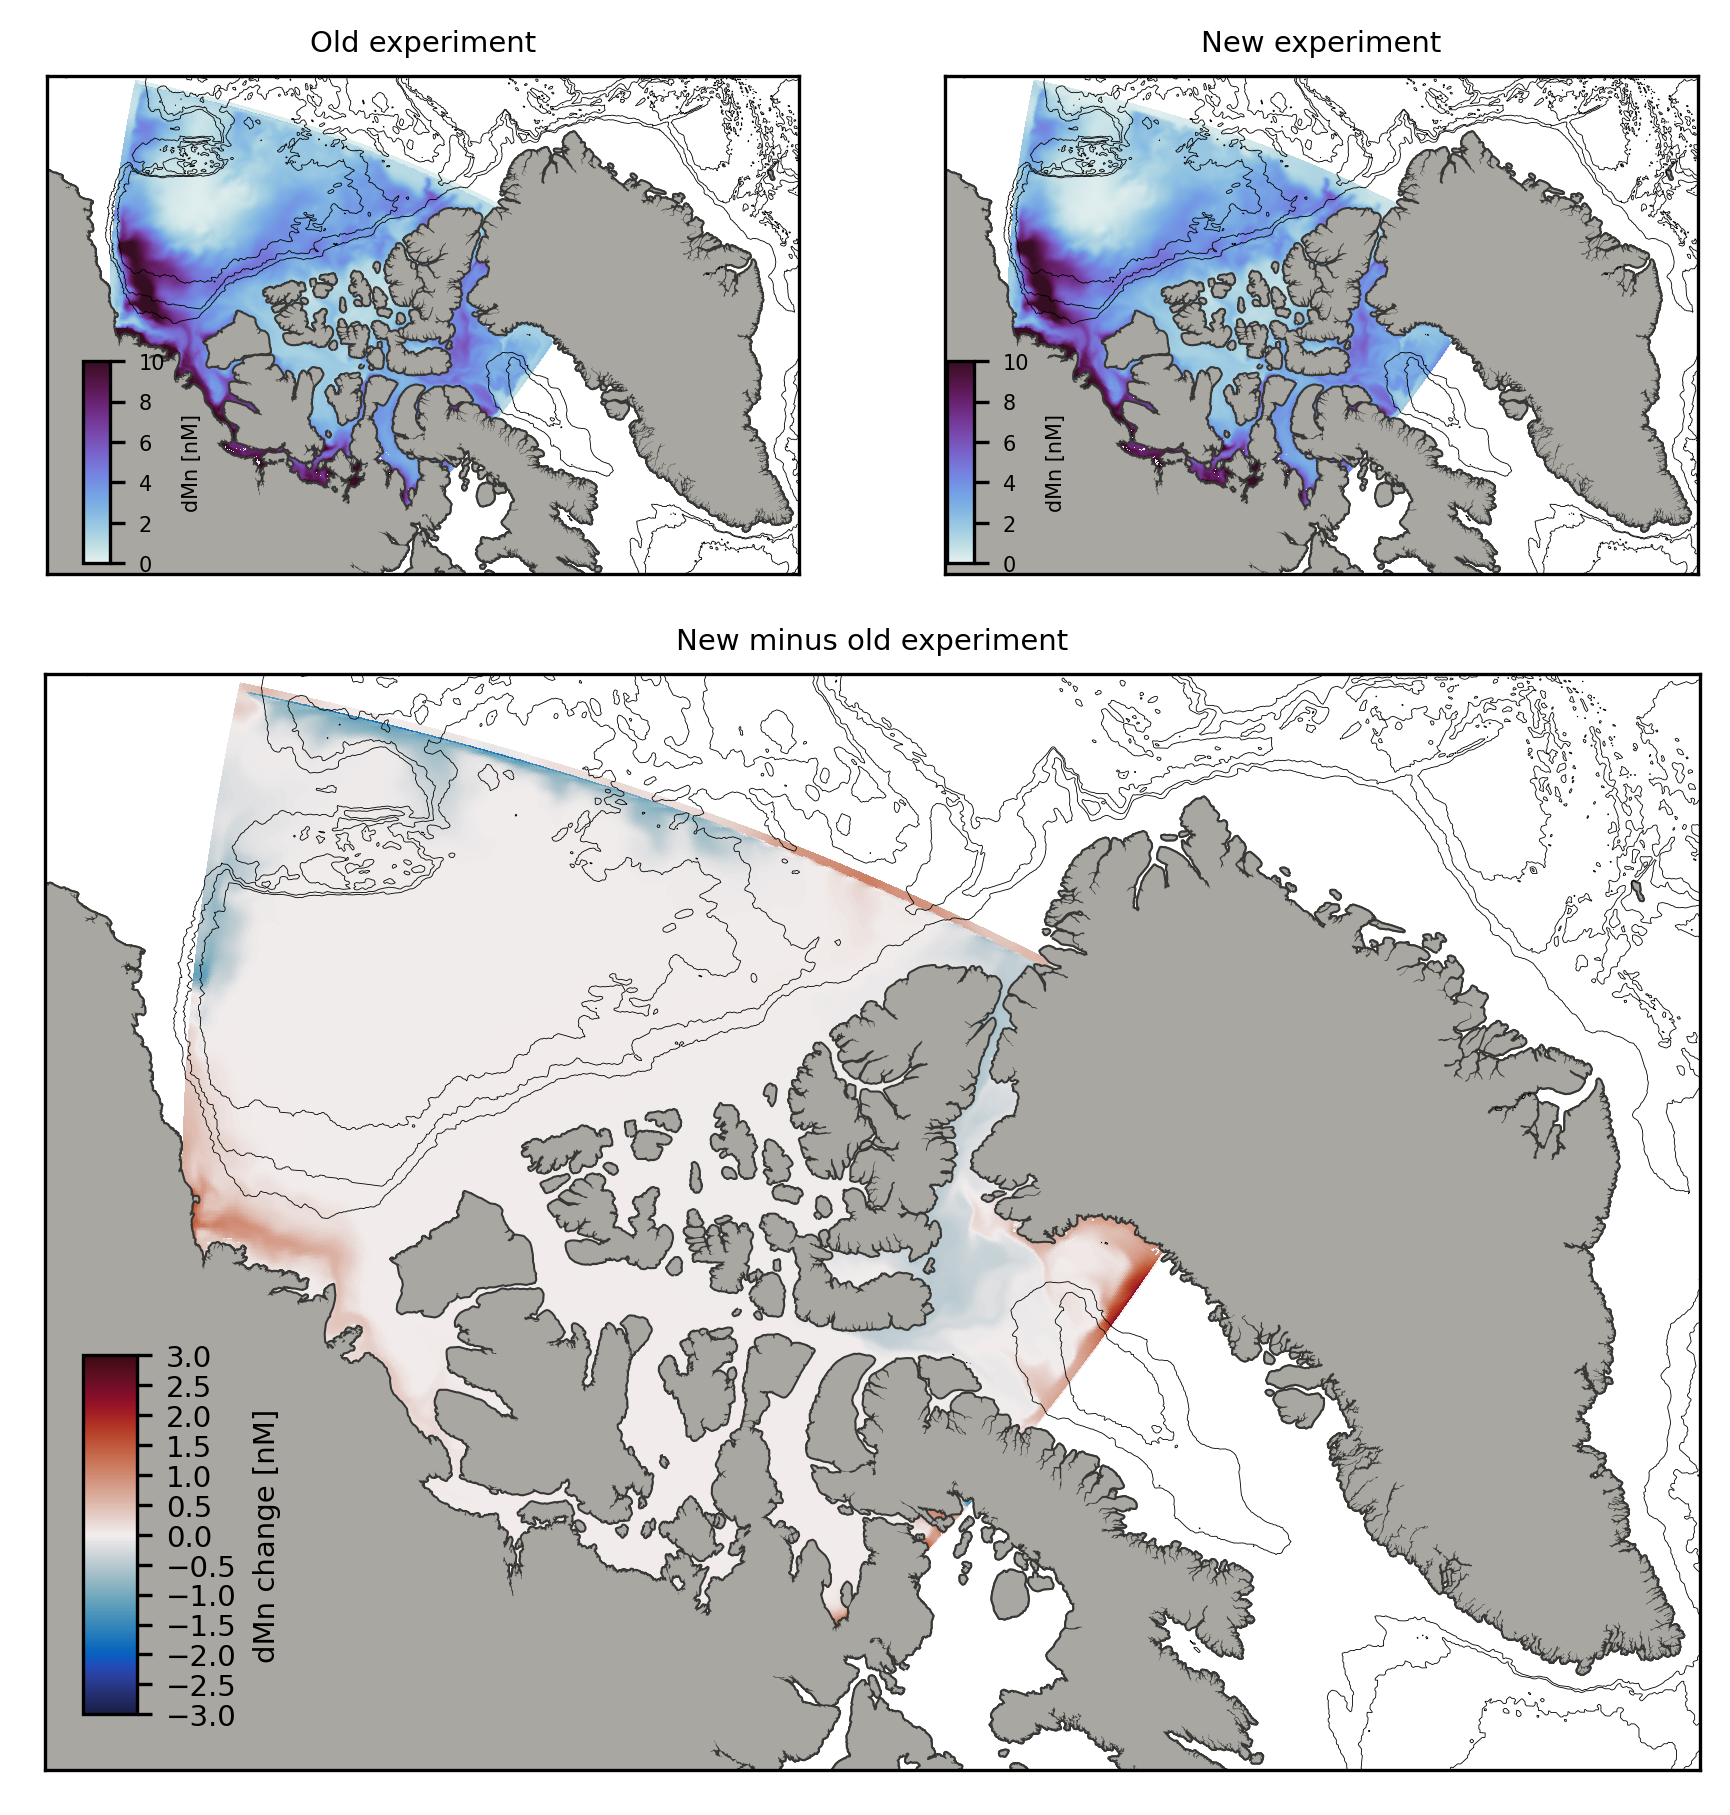

In [14]:
month=8
depth=0
mn_model_old = dMn_co[month,depth,:,:]
mn_model_new = dMn_cn[month,depth,:,:]
plot_slice(mn_model_old, mn_model_new, vmax1=10, vmax2=3.0, vmax2_step=0.5)

In [ ]:
month=8
depth=0
mn_model_old = dMn_go[month,depth,:,:]
mn_model_new = dMn_gn[month,depth,:,:]
plot_slice(mn_model_old, mn_model_new, vmax1=10, vmax2=3.0, vmax2_step=0.5)

In [ ]:
month=8
depth=0
mn_model_old = dMn_so[month,depth,:,:]
mn_model_new = dMn_sn[month,depth,:,:]
plot_slice(mn_model_old, mn_model_new, vmax1=10, vmax2=3.0, vmax2_step=0.5)